# Words of Warning: Inferring intent from text with Machine Learning

## Imports

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegressionCV as logreg
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer

import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from transformers import pipeline

pd.set_option('display.max_colwidth', 255)
plt.style.use("dark_background")

In [2]:
poli_pos = pd.read_csv('./data/poli_pos.csv')
poli_neg = pd.read_csv('./data/poli_neg.csv')
poli_val = pd.read_csv('./data/poli_val.csv')
topics_neg = pd.read_csv('./data/topics_neg.csv')
topics_pos = pd.read_csv('./data/topics_pos.csv')

In [3]:
poli_neg['target'] = 0 
poli_pos['target'] = 1 
topics_neg['target'] = 0
topics_pos['target'] = 1

In [4]:
print(poli_neg.columns)
print(poli_pos.columns)
print(topics_neg.columns)
print(topics_pos.columns)

Index(['Unnamed: 0', 'datetime', 'tweet_id', 'text', 'user_name', 'target'], dtype='object')
Index(['Unnamed: 0', 'datetime', 'tweet_id', 'text', 'user_name', 'target'], dtype='object')
Index(['Unnamed: 0', 'datetime', 'tweet_id', 'text', 'user_name', 'target'], dtype='object')
Index(['Unnamed: 0', 'datetime', 'tweet_id', 'text', 'keyword', 'target'], dtype='object')


In [5]:
# note: I will have to exclude the keyword column until I have added appropriate
# keywords throughout the data.  Right now there are too few, and they are too predictive.
poli_neg.drop(columns=['Unnamed: 0', 'tweet_id', 'user_name', 'datetime'], inplace=True)
poli_pos.drop(columns=['Unnamed: 0', 'tweet_id', 'user_name', 'datetime'], inplace=True)
topics_neg.drop(columns=['Unnamed: 0', 'tweet_id', 'user_name', 'datetime'], inplace=True)
topics_pos.drop(columns=['Unnamed: 0', 'tweet_id', 'datetime', 'keyword'], inplace=True)

In [6]:
df_topics = pd.concat([topics_pos, topics_neg], ignore_index=True)
df_poli = pd.concat([poli_pos, poli_neg], ignore_index=True)

In [7]:
X_poli = df_poli.drop(columns=['target'])
y_poli = df_poli['target']
X_topics = df_topics.drop(columns=['target'])
y_topics = df_topics['target']

In [8]:
# Split the data into the training and testing sets.
X_train_poli, X_test_poli, y_train_poli, y_test_poli = train_test_split(X_poli,
                                                                        y_poli,
                                                                        test_size=0.2,
                                                                        stratify=y_poli,
                                                                        random_state=42)

X_train_topics, X_test_topics, y_train_topics, y_test_topics = train_test_split(X_topics,
                                                                                y_topics,
                                                                                test_size=0.2,
                                                                                stratify=y_topics,
                                                                                random_state=42)

In [9]:
# custom stopwords to manually zero in on more predictive words

custom = ['https', 'trump', 'realdonaldtrump', 'rt', 'health', 'country', 
          'just', 'help', 'thank', 'time', 'senate', 'http', 'american', 
          'americans', 'act', 'vote', 'pandemic', 'like', 'america', 'state', 
          'support', 'day', 'workers', 'right', 'years', 'working', 'good', 
          'thanks', 'families', 'covid', 'crisis', 'election', 'big', 
          'congress', 'let', 'want', 'national', 'going', 'know', 'relief',  
          'house', 'public', 'year', 'federal', 'continue', 've', 
          'states', 'justice', 'way', 'ensure', 'jobs', 'law', 'businesses', 
          'proud', 'administration', 'small', 'world', 'stop', 'job', 'safe',
          'best', 'important', 'biden', 'doing', 'economy', 'better', 'needs',
          'week', 'join', 'funding', 'forward', 'economic', 'amp', 'did', 
          'millions', 'need', 'today', 'work', 'new']


combined_words = text.ENGLISH_STOP_WORDS.union(custom)

In [10]:
# implement countvectorizer
cvec = CountVectorizer(analyzer="word",
                       encoding='utf-8',
                       decode_error='ignore',
                       strip_accents='unicode',
                       lowercase=True,
                       max_df=0.95,
                       min_df=0.01,
                       stop_words=combined_words,
                       max_features=5000,
                       ngram_range=(1, 3))

tvec = TfidfVectorizer(encoding='utf-8',
                       decode_error='ignore',
                       strip_accents='unicode',
                       lowercase=True,
                       analyzer='word',
                       stop_words=combined_words,
                       ngram_range=(1, 3),
                       max_df=.8,
                       min_df=.05,
                       max_features=10000,
                       norm='l2')

lemmatizer = WordNetLemmatizer()

In [11]:
X_train_topics.isna().sum()

text    0
dtype: int64

In [12]:
X_test_topics.dropna(inplace=True)

<ipython-input-12-294d3c14820a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_topics.dropna(inplace=True)


In [13]:
for entry in X_train_poli['text']:
    entry = lemmatizer.lemmatize(entry)

In [14]:
for entry in X_test_poli['text']:
    entry = lemmatizer.lemmatize(entry)

In [15]:
for entry in X_train_topics['text']:
    entry = lemmatizer.lemmatize(entry)

In [16]:
for entry in X_test_topics['text']:
    entry = lemmatizer.lemmatize(entry)

In [17]:
# apply cvec to train and test sets
poli_X = pd.DataFrame(cvec.fit_transform(X_train_poli['text']).todense(),
                      columns=cvec.get_feature_names())

poli_X_test = pd.DataFrame(cvec.transform(X_test_poli['text']).todense(),
                           columns=cvec.get_feature_names())

In [18]:
topics_X = pd.DataFrame(cvec.fit_transform(X_train_topics['text']).todense(),
                      columns=cvec.get_feature_names())

topics_X_test = pd.DataFrame(cvec.transform(X_test_topics['text']).todense(),
                           columns=cvec.get_feature_names())

In [19]:
# # re-add the username and datetime columns to the temporary df, then replace the original with the vectorized version

# X_train_poli = pd.concat([poli_X, X_train_poli['datetime']], axis=1)
# X_test_poli = pd.concat([poli_X_test, X_test_poli['datetime']], axis=1)
# X_train_topics = pd.concat([topics_X, X_train_topics['datetime']], axis=1)
# X_test_topics = pd.concat([topics_X_test, X_test_topics['datetime']], axis=1)

In [20]:
l1 = logreg(cv=5,
            penalty='l1',
            scoring=None,
            solver='liblinear',
            tol=0.001,
            max_iter=200,
            class_weight='balanced',
            n_jobs=-2,
            verbose=1,
            refit=True,
            intercept_scaling=1.0,
            multi_class='auto',
            random_state=42,
            l1_ratios=None,)

l2 = logreg(cv=5,
            penalty='l2',
            scoring=None,
            solver='lbfgs',
            tol=0.001,
            max_iter=200,
            class_weight='balanced',
            n_jobs=-2,
            verbose=1,
            refit=True,
            intercept_scaling=1.0,
            multi_class='auto',
            random_state=42,
            l1_ratios=None,)

lr_net = logreg(cv=5,
                penalty='elasticnet',
                scoring=None,
                solver='saga',
                tol=0.001,
                max_iter=200,
                class_weight='balanced',
                n_jobs=-2,
                verbose=1,
                refit=True,
                intercept_scaling=1.0,
                multi_class='auto',
                random_state=42,
                l1_ratios=.5,)

In [21]:
poli_sc1 = StandardScaler()

poli_pipe1 = Pipeline([
    ('scaler', poli_sc1),
    ('model', l1)
])

Establishing null model:

In [22]:
y_train_poli.value_counts(normalize=True)

1    0.50144
0    0.49856
Name: target, dtype: float64

In [23]:
y_test_poli.value_counts(normalize=True)

1    0.501418
0    0.498582
Name: target, dtype: float64

In [24]:
poli_pipe1.fit(poli_X, y_train_poli)

poli_train1 = poli_pipe1.score(poli_X, y_train_poli)
poli_test1 = poli_pipe1.score(poli_X_test, y_test_poli)
print(f'LogReg L1, score on training set: {poli_train1}, score on test set: {poli_test1}.')

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   5 | elapsed:   17.6s remaining:   26.5s
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:   18.8s finished


LogReg L1, score on training set: 0.7529527777162232, score on test set: 0.7491579507179578.


In [25]:
poli_X.sum().sort_values(ascending=False).head(50)

great          7754
president      7499
people         7128
make           4486
care           3683
coronavirus    2957
don            2692
covid19        2379
donald         2281
news           2278
nation         2217
communities    2150
protect        2148
democrats      2137
19             2095
fight          2084
republicans    1789
obama          1764
ll             1732
000            1704
lives          1691
win            1546
million        1520
family         1518
court          1515
watch          1511
sure           1500
women          1488
china          1439
fighting       1436
bipartisan     1378
look           1371
pass           1364
provide        1364
said           1360
military       1356
united         1346
service        1346
deal           1345
long           1339
security       1329
live           1325
love           1319
tonight        1317
won            1306
think          1304
access         1299
hard           1290
testing        1270
end            1260


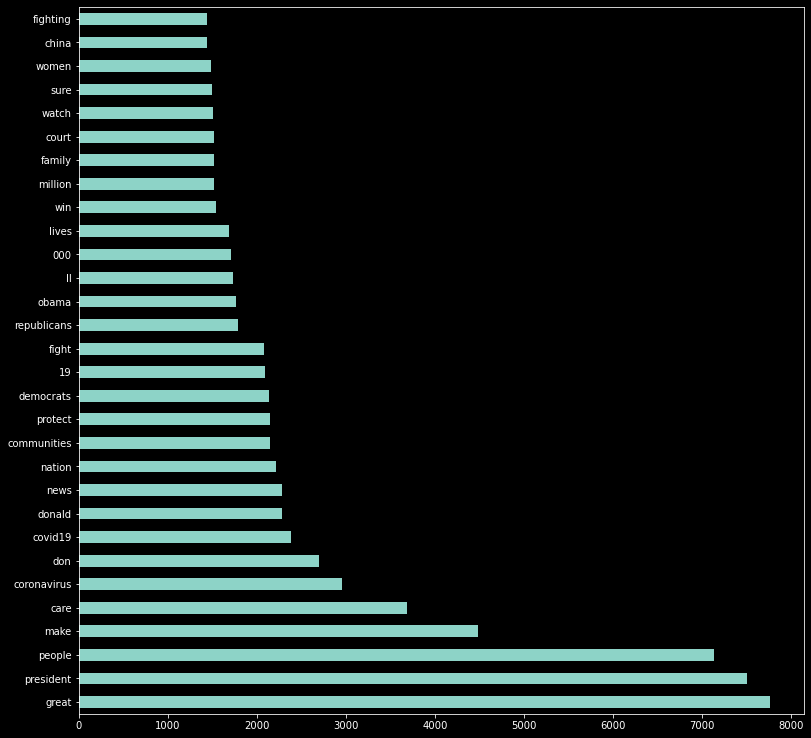

In [26]:
# plot top occuring words
poli_X.sum().sort_values(ascending=False).head(30).plot(kind='barh', figsize=(13,13));

In [27]:
poli_sc2 = StandardScaler()

poli_pipe2 = Pipeline([
    ('scaler', poli_sc2),
    ('model', l2)
])

In [28]:
poli_pipe2.fit(poli_X, y_train_poli)

poli_train2 = poli_pipe2.score(poli_X, y_train_poli)
poli_test2 = poli_pipe2.score(poli_X_test, y_test_poli)
print(f'LogReg L2, score on training set: {poli_train2}, score on test set: {poli_test2}.')

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   5 | elapsed:    5.8s remaining:    8.7s
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    6.1s finished


LogReg L2, score on training set: 0.7529860172402332, score on test set: 0.7492465874844886.


In [29]:
rf = RandomForestClassifier(n_estimators=250,
                            criterion='gini',
                            max_depth=5,
                            min_samples_split=2,
                            min_samples_leaf=1,
                            min_weight_fraction_leaf=0.0,
                            max_features='auto',
                            max_leaf_nodes=None,
                            min_impurity_decrease=0.0,
                            min_impurity_split=None,
                            bootstrap=True,
                            oob_score=False,
                            n_jobs=None,
                            random_state=None,
                            verbose=0,
                            warm_start=False,
                            class_weight=None,
                            ccp_alpha=0.0,
                            max_samples=None,
                            )

In [30]:
poli_sc4 = StandardScaler()

poli_pipe4 = Pipeline([
    ('scaler', poli_sc1),
    ('model', rf)
])

In [31]:
poli_pipe4.fit(poli_X, y_train_poli)

poli_train4 = poli_pipe4.score(poli_X, y_train_poli)
poli_test4 = poli_pipe4.score(poli_X_test, y_test_poli)
print(f'Random Forest, score on training set: {poli_train4}, score on test set: {poli_test4}.')

Random Forest, score on training set: 0.7038690805947658, score on test set: 0.700008863676653.


In [32]:
# currently not working, unsure why

# Train
rf.fit(poli_X, y_train_poli)
# Extract single tree
estimator = rf.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = poli_X.columns,
                class_names = y_train_poli,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

TypeError: can only concatenate str (not "numpy.int64") to str

In [ ]:
topics_sc1 = StandardScaler()

topics_pipe1 = Pipeline([
    ('scaler', topics_sc1),
    ('model', l1)
])

In [ ]:
topics_pipe1.fit(topics_X, y_train_poli)

topics_train1 = topics_pipe1.score(topics_X, topics)
topics_test1 = topics_pipe1.score(topics_X_test, topics)
print(f'LogReg L2, score on training set: {topics_train1}, score on test set: {topics_test1}.')

In [ ]:
poli_cvec = pd.DataFrame(cvec.fit_transform(df_poli['text']).todense(), 
                         columns=cvec.get_feature_names())

poli_cvec.sum().sort_values(ascending=False).head(10).plot(kind='barh');

In [ ]:
# convert training data to dataframe
poli_tiff = pd.DataFrame(tvec.fit_transform(df_poli['text']).todense(), 
                          columns=tvec.get_feature_names())

# plot top occuring words
poli_tiff.sum().sort_values(ascending=False).head(10).plot(kind='barh');